## Projecting Cohort Fertility Rates

This notebook uses PyMC to model and predict fertility rates in the United States, using preprocessed data from the US Census.

Background article on fertility rates: "[Why the total fertility rate doesn't necessarily tell us the number of births women eventually have](https://ourworldindata.org/total-fertility-rate-births-per-woman)" 

**Note:** Run `process_cps.ipynb` first to generate the preprocessed data file.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/BayesFertility/blob/main/fertility_cps.ipynb)

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/BayesFertility/raw/main/utils.py")

In [2]:
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc as pm

from utils import decorate, value_counts, save_baseline_results, load_baseline_results
import os

In [3]:
# Make the figures smaller to save some screen real estate.
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6.75, 3.5]

## Load Preprocessed Data

Load the preprocessed data from the preprocessing notebook.

In [4]:
filename = "../data/fertility_cps_preprocessed.h5"

# Load the aggregated data
sum_df = pd.read_hdf(filename, key='sum_df')
count_df = pd.read_hdf(filename, key='count_df')
cfr_cps = pd.read_hdf(filename, key='cfr_cps')

# Load labels
age_labels = pd.read_hdf(filename, key='age_labels').values
cohort_labels = pd.read_hdf(filename, key='cohort_labels').values

# Load metadata
metadata = pd.read_hdf(filename, key='metadata')
cutoff_year = int(metadata['cutoff_year'])

print(f"Loaded preprocessed data from {filename}")
print(f"Cutoff year: {cutoff_year}")
print(f"Shape: {sum_df.shape}")

Loaded preprocessed data from ../data/fertility_cps_preprocessed.h5
Cutoff year: 2024
Shape: (30, 14)


## The Model

For the most recent generations, we have limited data.
To project what future fertility rates will look like, we'll use a model to estimate cohort and age effects, then use the model to generate predictions.

The following PyMC model is based on a log-linear model of age cohort effects -- that is, each cohort has a latent value, $\alpha$, that indicates their overall proclivity to have children, and each age group has a latent value, $\beta$, that indicates the tendency of people to have children at that age.

The average number of children borne by a particular cohort during a given 3-year span is $\lambda = \exp \alpha + \beta$.
So the average parity of a cohort at a given age is the cumulative sum of these rates up to their current age.

Both $\alpha$ and $\beta$ are modeled with a Gaussian random walk, which indicates that we expect the difference between successive cohorts, and between successive age groups, to follow a Gaussian distribution.
As a result, each value is estimated relative to its predecessor, so in the absence of enough data to infer a change, each value is presumed to be unchanged.
We'll see the consequences of this structure in the results.

The values of $\alpha$ are constrained so their mean is 0.
This is useful because the location of the $\alpha$ and $\beta$ coefficients is arbitrary; this constraint establishes a zero point.

Finally, if we are given the size and expected parity of a cohort-age group, we expect the observed data to follow a Poisson distribution with the given mean.

In [5]:
def make_model(sum_array, count_array):
    with pm.Model() as model:
        n_cohorts, n_ages = sum_array.shape

        # Random walk prior for cohort effects with mean constraint
        sigma_alpha = pm.HalfNormal("sigma_alpha", sigma=0.1)
        alpha = pm.GaussianRandomWalk(
            "alpha",
            sigma=sigma_alpha,
            shape=n_cohorts,
            init_dist=pm.Normal.dist(mu=0, sigma=0.5),
        )

        # Soft constraint to enforce mean zero without hard subtraction
        pm.Potential(
            "zero_mean_constraint", pm.logp(pm.Normal.dist(0, 0.001), 
                                            pm.math.mean(alpha))
        )

        # Random walk prior for age effects
        sigma_beta = pm.HalfNormal("sigma_beta", sigma=0.3)
        beta = pm.GaussianRandomWalk(
            "beta",
            sigma=sigma_beta, 
            shape=n_ages,
            init_dist=pm.Normal.dist(mu=0, sigma=1)
        )

        # Log-linear model for the ASBR
        log_lambda = alpha[:, None] + beta[None, :]
        lambda_ = pm.Deterministic("lambda", pm.math.exp(log_lambda))

        # Observed parity depends on the cumulative sum of ASBRs
        cumulative_lambda = pm.math.cumsum(lambda_, axis=1)

        # Likelihood, ignoring unobserved cohort-age pairs
        mask = count_array != 0
        y_obs = pm.Poisson(
            "y_obs", mu=(count_array * cumulative_lambda)[mask], observed=sum_array[mask]
        )
        
        return model

In [6]:
count_array = count_df.to_numpy()
sum_array = sum_df.to_numpy()

To see whether the prior distributions make sense, we'll look at the prior predictive distribution of $\lambda$.

In [7]:
model = make_model(sum_array, count_array)

In [8]:
with model:
    prior_predictive = pm.sample_prior_predictive(1000)

lambda_prior_samples = (
    prior_predictive.prior["lambda"].stack(sample=("chain", "draw")).values
)

/tmp/ipykernel_265282/1437896971.py:2: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  prior_predictive = pm.sample_prior_predictive(1000)
Sampling: [alpha, beta, sigma_alpha, sigma_beta, y_obs]


In [9]:
pd.Series(lambda_prior_samples.flatten()).describe()

count    420000.000000
mean          4.574406
std          88.656043
min           0.000605
25%           0.415507
50%           1.022029
75%           2.579547
max       11516.054306
dtype: float64

Now let's sample the posterior distribution.
In general, the model samples well.

In [10]:
from utils import load_idata_or_sample

idata_filename = f"nc/fertility_cps_idata_{cutoff_year}_v3.nc"

idata = load_idata_or_sample(
    model, idata_filename, nuts_sampler="nutpie", force_run=True, random_seed=17
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.33,15
,2000,0,0.31,15
,2000,0,0.30,15
,2000,0,0.34,15


Saved new idata to nc/fertility_cps_idata_2024_v3.nc


In [11]:
pm.summary(idata, var_names=["sigma_alpha", "sigma_beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma_alpha,0.094,0.015,0.070,0.122,0.000,0.000,4802.0,3323.0,1.0
sigma_beta,0.786,0.128,0.572,1.043,0.002,0.002,3374.0,2765.0,1.0


### Cohort effects

Here is a summary of the cohort effects.

In [12]:
alpha_summary = pm.summary(idata, var_names=["alpha"])
alpha_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.429,0.014,0.404,0.457,0.000,0.000,4808.0,2780.0,1.00
alpha[1],0.465,0.009,0.447,0.481,0.000,0.000,2073.0,2435.0,1.00
alpha[2],0.504,0.007,0.491,0.518,0.000,0.000,1346.0,2182.0,1.00
alpha[3],0.529,0.007,0.516,0.542,0.000,0.000,1293.0,2200.0,1.00
alpha[4],0.531,0.007,0.518,0.543,0.000,0.000,1290.0,2087.0,1.00
alpha[5],0.495,0.007,0.483,0.508,0.000,0.000,1228.0,1981.0,1.00
alpha[6],0.414,0.006,0.402,0.426,0.000,0.000,1163.0,2224.0,1.00
alpha[7],0.317,0.006,0.306,0.329,0.000,0.000,976.0,1671.0,1.00
alpha[8],0.211,0.006,0.200,0.222,0.000,0.000,958.0,1575.0,1.00
alpha[9],0.149,0.006,0.139,0.160,0.000,0.000,883.0,1544.0,1.00


In [13]:
def forest_plot(summary, labels, **options):
    means = summary["mean"].to_numpy()
    hdi_lower = summary["hdi_3%"].to_numpy()
    hdi_upper = summary["hdi_97%"].to_numpy()

    n_cohorts = len(means)
    x_positions = np.arange(n_cohorts)
    plt.xticks(x_positions, labels, **options)

    plt.errorbar(
        x_positions,
        means,
        yerr=[means - hdi_lower, hdi_upper - means],
        fmt="o",
        markersize=4,
        capsize=2,
        color="C0",
    )

And here's what they look like:

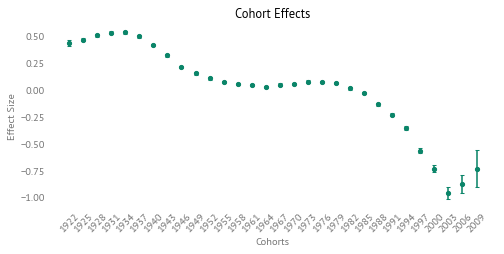

In [14]:
forest_plot(alpha_summary, cohort_labels, rotation=45)
plt.ylabel("Effect Size")
plt.xlabel("Cohorts")
plt.title("Cohort Effects")
plt.tight_layout()

Qualitatively, the trend is what we expect to see.
The proclivity to have children is highest in the 1937 and 1940 cohorts, who had their babies at the tail end of the baby boom.
It's mostly unchanged from 1943 to 1982, declines slowly until 1991, and then declines more quickly.

The error bars are wider in the most recent cohorts, where we have less data.
In the most recent cohorts, we see a useful property of the random walk -- if there is not enough data to be confident that there is a change, it assumes that there is no change.
For example, the central estimates for the 2006 and 2009 cohorts are about the same, because there is not enough data in the 2009 cohort to provide strong evidence of a difference.

This is different from what we would see in a hierarchical model, where in the absence of sufficient data, estimates are centered on the overall mean, not the most recent mean.

The model is conservative in the sense that it does not extrapolate trends -- although it looks like this proclivity has declined consistently over the last 30 years, the model does not assume that this trend will continue.

### Age effects

Here is a summary of the age effects.

In [15]:
beta_summary = pm.summary(idata, var_names=["beta"])
beta_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],-3.467,0.028,-3.515,-3.410,0.000,0.000,5117.0,2930.0,1.0
beta[1],-2.178,0.015,-2.207,-2.150,0.000,0.000,2843.0,2925.0,1.0
beta[2],-1.349,0.011,-1.370,-1.328,0.000,0.000,1849.0,2665.0,1.0
beta[3],-1.155,0.013,-1.179,-1.132,0.000,0.000,1902.0,2569.0,1.0
beta[4],-1.105,0.014,-1.132,-1.079,0.000,0.000,1765.0,2629.0,1.0
beta[5],-1.242,0.018,-1.277,-1.208,0.000,0.000,1993.0,2606.0,1.0
beta[6],-1.395,0.023,-1.439,-1.351,0.001,0.000,1899.0,2327.0,1.0
beta[7],-1.759,0.034,-1.824,-1.697,0.001,0.001,2351.0,2877.0,1.0
beta[8],-2.955,0.108,-3.158,-2.761,0.002,0.002,2551.0,2300.0,1.0
beta[9],-4.577,0.383,-5.294,-3.946,0.007,0.010,3383.0,2365.0,1.0


And here's what they look like.

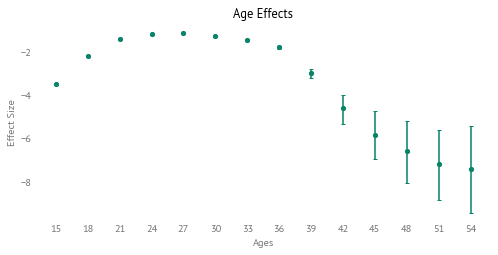

In [16]:
forest_plot(beta_summary, age_labels)

plt.ylabel("Effect Size")
plt.xlabel("Ages")
plt.title("Age Effects")
plt.tight_layout()

Qualitatively, the trends here are what we expect: women are most likely to have children when they are 21-33 years old.

In the age groups where we have less data, the error bars are wider.
And again, the model does not extrapolate trends, so the estimates level off in the oldest groups.

## Prediction

Now we can use the model to generate predictive distributions for each cohort-age group, including retrodictions for the groups where we have data, and predictions for the groups where we have little or none.

In [17]:
with model:
    # Generate posterior predictive samples
    posterior_predictive = pm.sample_posterior_predictive(
        idata, var_names=["lambda"], random_seed=42
    )

    # Compute expected cumulative births for each draw
    lambda_samples = posterior_predictive.posterior_predictive[
        "lambda"
    ].values  # Shape: (chains, draws, n_cohorts, n_ages)

    cumulative_lambda_pred = np.cumsum(
        lambda_samples, axis=-1
    )  # Compute cumulative sum along age axis

/tmp/ipykernel_265282/1989232934.py:3: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior_predictive = pm.sample_posterior_predictive(
Sampling: []


Output()

The result we want is the `cumulative_lambda_pred` array, which contains the expected parity for each cohort-age group.
We can compute the mean by combining the first two axes from the results, averaging over the chains and the draws from each chain.

In [18]:
mean = cumulative_lambda_pred.mean(axis=(0, 1))
hdi = pm.hdi(cumulative_lambda_pred)

I'll put the results in a `DataFrame` so we can see the cohort and age labels.
Reading across the bottom line, we can see the predictions for women born in 2009.

In [19]:
mean_cumulative_rate = pd.DataFrame(mean, index=cohort_labels, columns=age_labels)
mean_cumulative_rate.tail()

,15,18,21,24,27,30,33,36,39,42,45,48,51,54
1997,0.017702,0.081881,0.228877,0.407477,0.595271,0.758982,0.899451,0.997141,1.026814,1.033048,1.035088,1.036111,1.036715,1.037297
2000,0.014969,0.069238,0.193537,0.344561,0.503365,0.641795,0.760575,0.843181,0.868272,0.873544,0.875268,0.876133,0.876643,0.877135
2003,0.011940,0.055229,0.154379,0.274851,0.401523,0.511948,0.606696,0.672590,0.692605,0.696809,0.698185,0.698875,0.699282,0.699674
2006,0.013009,0.060180,0.168224,0.299495,0.437524,0.557851,0.661095,0.732898,0.754709,0.759289,0.760789,0.761541,0.761985,0.762412
2009,0.014930,0.069072,0.193083,0.343754,0.502179,0.640287,0.758793,0.841193,0.866235,0.871491,0.873213,0.874075,0.874585,0.875076


Now let's see what the error bounds look like.

In [20]:
low = pd.DataFrame(hdi[:, :, 0], index=cohort_labels, columns=age_labels)
high = pd.DataFrame(hdi[:, :, 1], index=cohort_labels, columns=age_labels)

The following figure shows Completed Cohort Fertility Rate (CFR), which is the average number of children born to women from a specific birth cohort by the end of their reproductive years -- taken to be 42 to be consistent with the midpoint of the range used by CPS, 40-44.

In [21]:
# Define the age for CFR calculation
cfr_age = 42

We'll use age `cfr_age` for the CFR calculations.

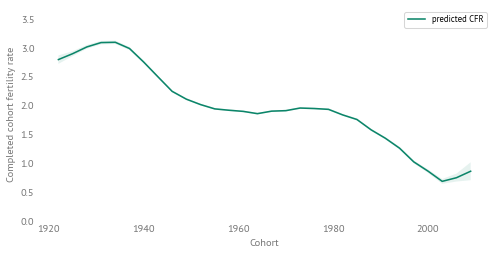

In [22]:
cfr_cohort = mean_cumulative_rate[cfr_age]
plt.fill_between(low.index, low[cfr_age], high[cfr_age], alpha=0.1)
cfr_cohort.plot(label="predicted CFR")
decorate(xlabel="Cohort", ylabel="Completed cohort fertility rate", ylim=[0, 3.7])

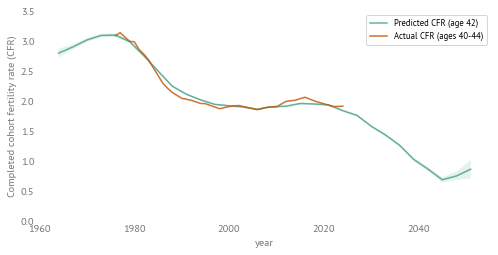

In [23]:
cfr_shifted = pd.Series(cfr_cohort.values, cfr_cohort.index + cfr_age, copy=True)
plt.fill_between(cfr_shifted.index, low[cfr_age], high[cfr_age], alpha=0.1)
cfr_shifted.plot(alpha=0.6, label=f"Predicted CFR (age {cfr_age})")

cfr_cps.plot(alpha=0.8, label="Actual CFR (ages 40-44)")
decorate(ylabel="Completed cohort fertility rate (CFR)", ylim=[0, 3.5])

The model predicts that CFR will decline steeply, starting with women born around 1980, and reaching very low levels for the most recent cohorts.

The error bounds show 94% credible intervals that take into account the uncertainty of the estimated coefficients, but we should not take them too seriously because they don't take into account the far larger source of uncertainty -- any number of things that could happen in the future that would affect these outcomes.

I suggest we think of these results as projections rather than predictions -- that is, they show us what we would expect in the future if the structure of the model is appropriate, the estimated parameters are accurate, and nothing changes in the future that substantially affects the outcome.

Considering the structure of the model, the most obvious omission is the possibility of a "rebound" effect, where a cohort that has fewer children when they are young goes on to have more children when they are older, with the effect of closing the CFR gap with previous generations.

Of course that could happen, and possible extensions to the model could either add an interaction term that estimates the rebound in previous generations, or a "what if" parameter that lets us explore the effect of different levels of rebound on future CFR.

We can come back to this question, but first let's consider whether the model has adequately captured the structure of the data.

The results show that, unless there is a substantial shift toward higher fertility, starting soon, we should expect a large decline in CFR over the next 30 years, comparable in speed and magnitude to the previous decline at the end of the baby boom.

Of course, predictions 30 years into the future are unlikely to be precise, but if we take the results of the model at face value, it is plausible that CFR will drop below 1.0 between 2040 and 2050, comparable to levels in South Korea now.
At that level, barring large-scale immigration, the population of the United States would decline quickly.

## Compare model to data

The following function plots observed average parity in each cohort-age group along with the estimates from the model.
Where we have data, we can see if the retrodictions fit it.
And where we are missing data, we can see if the predictions seem plausible.

In [24]:
def plot_cohorts(mean_parity_df, start, end):
    cohorts = mean_parity_df.index[start:end]
    palette = list(sns.color_palette("nipy_spectral", len(cohorts)))

    for i, cohort in enumerate(cohorts):
        mean_parity_df.loc[cohort].plot(
            style="o", color=palette[i], alpha=0.8, label=cohort
        )
        mean_cumulative_rate.loc[cohort].plot(
            style=":", color=palette[i], alpha=0.6, label=""
        )

    decorate(xlabel="Age")

Here are the results for women born in the 1990s and 2000s.

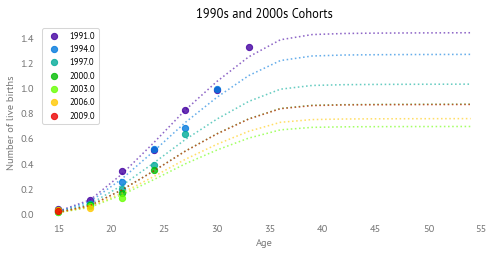

In [25]:
mean_parity_df = sum_df / count_df
plot_cohorts(mean_parity_df, -7, None)
decorate(ylabel="Number of live births", title="1990s and 2000s Cohorts")

Looking at the top line, we can see that the retrodictions for the 1991 cohort fit the data well.

In [26]:
# Example: Check parity at age 33 and predicted CFR
# mean_parity_df.loc[1991, 33], mean_cumulative_rate.loc[1991, cfr_age]

As expected, predicted CFRs for successive cohorts are lower.
The projections for the last two cohorts overlap because the estimates for their cohort effects are almost the same.

Here are the results for women born in the 1970s and 1980s.

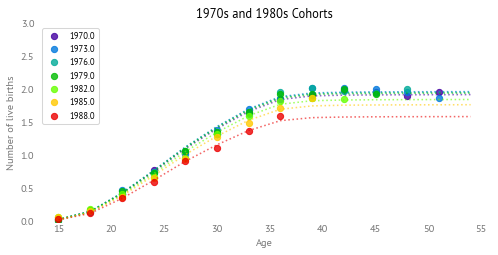

In [27]:
plot_cohorts(mean_parity_df, -14, -7)
decorate(ylim=[0, 3], ylabel="Number of live births", title="1970s and 1980s Cohorts")

The model seems to capture the structure of the data well.
Here are the results for women born in the 1950s and 1960s.

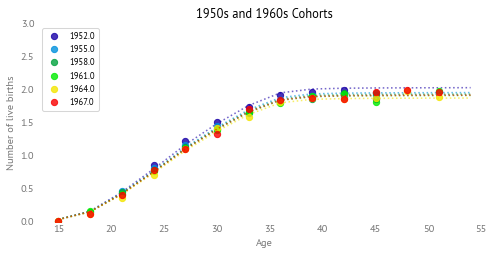

In [28]:
plot_cohorts(mean_parity_df, -20, -14)
decorate(ylim=[0, 3], ylabel="Number of live births", title="1950s and 1960s Cohorts")

The estimated CFRs for these cohorts are not very different.

Finally here are the results for women born in the 1940s and the end of the 1930s.

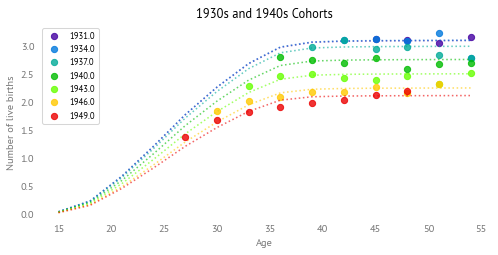

In [29]:
plot_cohorts(mean_parity_df, -27, -20)
decorate(ylabel="Number of live births", title="1930s and 1940s Cohorts")

Here we see the decline in total fertility that characterized the end of the baby boom.

Overall, the model seems to capture the structure of the data, and its projections are plausible in the sense that they are based on the assumption that the future will be like the past.

## Regression testing

In [30]:
# Save baseline results for regression testing
# Use the same cfr_age as defined above (42, to match CPS range 40-44)
# cfr_age is already defined earlier in the notebook

# Prepare CFR data with HDI bounds
cfr_df = pd.DataFrame({
    'cohort': cohort_labels,
    'mean': mean_cumulative_rate[cfr_age].values,
    'low': low[cfr_age].values,
    'high': high[cfr_age].values
})

# Save all three outputs as v3.0
model_version = "v3.0"
save_baseline_results(
    version=model_version,
    alpha_summary=alpha_summary,
    beta_summary=beta_summary,
    cfr_df=cfr_df,
    cohort_labels=cohort_labels,
    age_labels=age_labels
)

Saved baseline results to results/fertility_cps_v3.0.h5


In [31]:
# Load v2.0 results and compare with v3.0
baseline = load_baseline_results("v2.0")

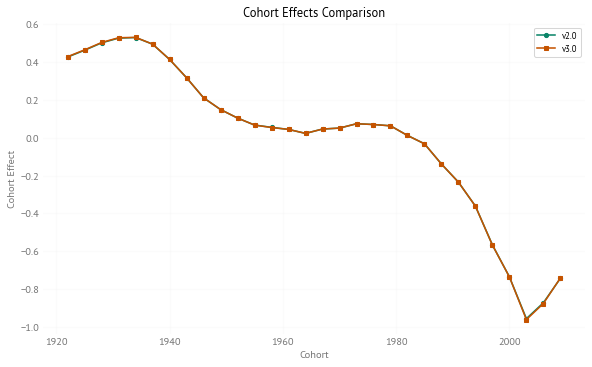

In [32]:
# Compare cohort effects
plt.figure(figsize=(8, 5))
plt.plot(baseline['alpha']['cohort'], baseline['alpha']['mean'], 'o-', label='v2.0', markersize=4)
plt.plot(cohort_labels, alpha_summary['mean'], 's-', label='v3.0', markersize=4)
plt.legend()
plt.xlabel('Cohort')
plt.ylabel('Cohort Effect')
plt.title('Cohort Effects Comparison')
plt.grid(True, alpha=0.3)
decorate()

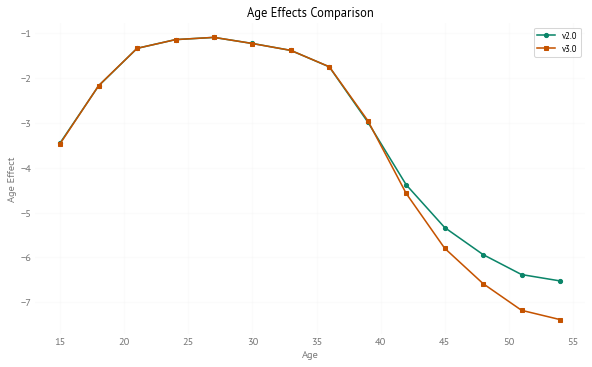

In [33]:
# Compare age effects
plt.figure(figsize=(8, 5))
plt.plot(baseline['beta']['age'], baseline['beta']['mean'], 'o-', label='v2.0', markersize=4)
plt.plot(age_labels, beta_summary['mean'], 's-', label='v3.0', markersize=4)
plt.legend()
plt.xlabel('Age')
plt.ylabel('Age Effect')
plt.title('Age Effects Comparison')
plt.grid(True, alpha=0.3)
decorate()

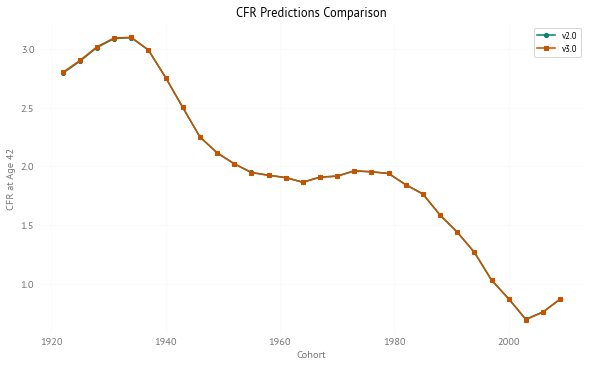

In [34]:
# Compare CFR predictions
plt.figure(figsize=(8, 5))
plt.plot(baseline['cfr_df']['cohort'], baseline['cfr_df']['mean'], 'o-', label='v2.0', markersize=4)
plt.plot(cohort_labels, mean_cumulative_rate[cfr_age], 's-', label='v3.0', markersize=4)
plt.legend()
plt.xlabel('Cohort')
plt.ylabel(f'CFR at Age {cfr_age}')
plt.title('CFR Predictions Comparison')
plt.grid(True, alpha=0.3)
decorate()

In [35]:
from utils import beep

beep()